In [4]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

In [6]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [7]:
mlflow_tracking_uri = "http://localhost:5555"


In [8]:
# load dataset
data_path = '../data/processed/featured_house_data.csv'
data = pd.read_csv(data_path)
X = data.drop(columns=['price'])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# rfe
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)  
rfe_selector_features = X_train.columns[rfe_selector.support_]
rfe_ignore_features = X_train.columns[~rfe_selector.support_]

print('Top 10 features selected by RFE:')
print(rfe_selector_features.tolist())

print('Features ignored by RFE:')
print(rfe_ignore_features.tolist())

# store the selected features
selected_features_dict= {
    'rfe': rfe_selector_features.tolist(),
}

X_train_rfe = X_train[rfe_selector_features]
X_test_rfe = X_test[rfe_selector_features]


Top 10 features selected by RFE:
['0', '2', '3', '4', '5', '9', '12', '13', '14', '15']
Features ignored by RFE:
['1', '6', '7', '8', '10', '11']


In [12]:
# Optional MLflow setup
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction Experiment")

2025/07/27 21:43:40 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction Experiment' does not exist. Creating a new experiment.


In [13]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    }
}


In [14]:
def evaluate_model_with_gridsearch(name, model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf= GridSearchCV(model, grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()
        
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2_score': r2,
        'model': best_model,
        'params': best_params
    }
    
    print(f'ML Flow Tracking URI: {mlflow_tracking_uri}')

In [16]:
results = {}

with mlflow.start_run(run_name= 'model_comparision') as run:
    for name, model in models.items():
        logger.info(f"Evaluating model: {name}")
        with mlflow.start_run(run_name=name, nested= True):
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], X_train_rfe, y_train, X_test_rfe, y_test)
            results[name] = evaluation
            
            if mlflow_tracking_uri:
                mlflow.log_param("model_name", name)
                mlflow.log_params(evaluation['params'])
                mlflow.log_metric("mae", evaluation['mae'])
                mlflow.log_metric("mse", evaluation['mse'])
                mlflow.log_metric("rmse", evaluation['rmse'])
                mlflow.log_metric("r2_score", evaluation['r2_score'])
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
                
            print(f"{name} R2: {evaluation['r2_score']:.4f}, RMSE: {evaluation['rmse']:.2f}")

INFO:root:Evaluating model: LinearRegression
2025/07/27 21:54:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/27 21:54:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:root:Evaluating model: RandomForest


LinearRegression R2: 0.9818, RMSE: 29099.30
🏃 View run LinearRegression at: http://localhost:5555/#/experiments/1/runs/209a209b6eab46afa973f3e8235c603f
🧪 View experiment at: http://localhost:5555/#/experiments/1


2025/07/27 21:54:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/27 21:54:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:root:Evaluating model: GradientBoosting


RandomForest R2: 0.9886, RMSE: 23037.15
🏃 View run RandomForest at: http://localhost:5555/#/experiments/1/runs/3f105de579184756a448f65cad2e2cc6
🧪 View experiment at: http://localhost:5555/#/experiments/1


2025/07/27 21:54:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/27 21:54:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:root:Evaluating model: XGBoost


GradientBoosting R2: 0.9964, RMSE: 12910.47
🏃 View run GradientBoosting at: http://localhost:5555/#/experiments/1/runs/ca688bbf277440b98e203096faab6db6
🧪 View experiment at: http://localhost:5555/#/experiments/1


2025/07/27 21:54:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/27 21:54:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost R2: 0.9744, RMSE: 34525.22
🏃 View run XGBoost at: http://localhost:5555/#/experiments/1/runs/aa73646e78794eafb8afb98cd8e32878
🧪 View experiment at: http://localhost:5555/#/experiments/1
🏃 View run model_comparision at: http://localhost:5555/#/experiments/1/runs/387784428a52481d9e1a3c847e296d88
🧪 View experiment at: http://localhost:5555/#/experiments/1


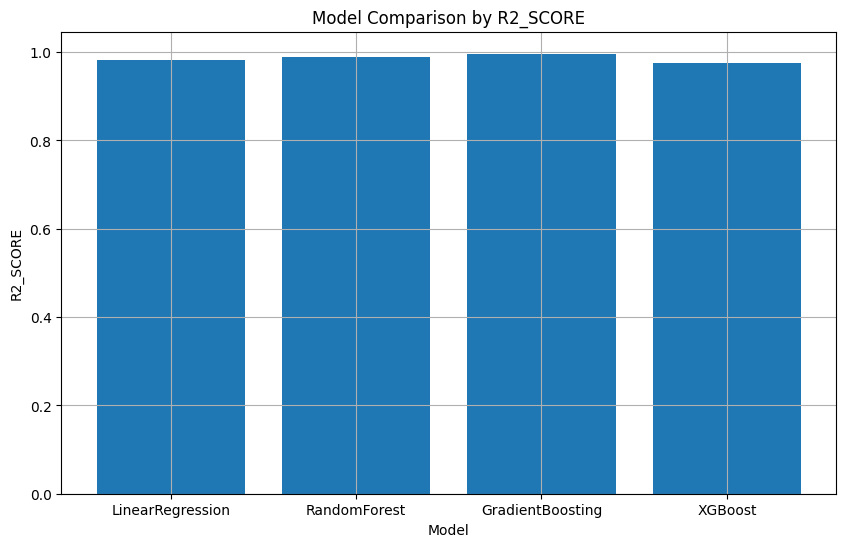

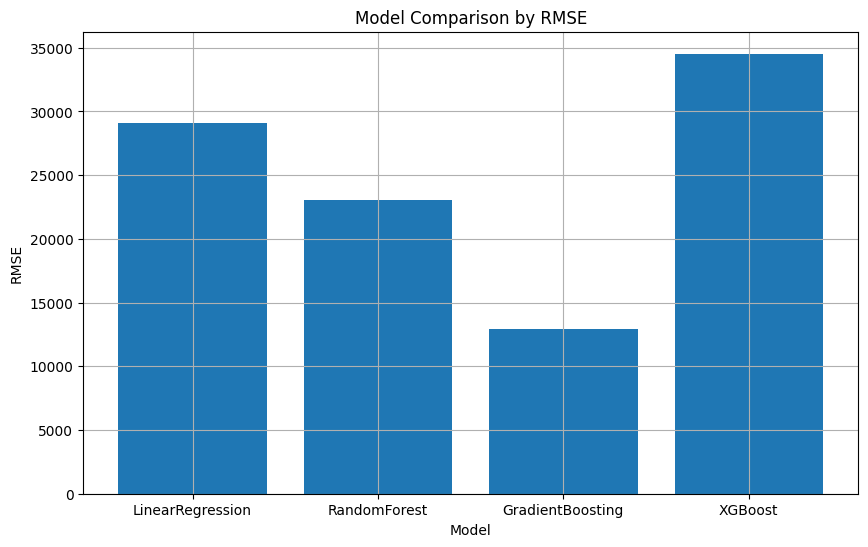

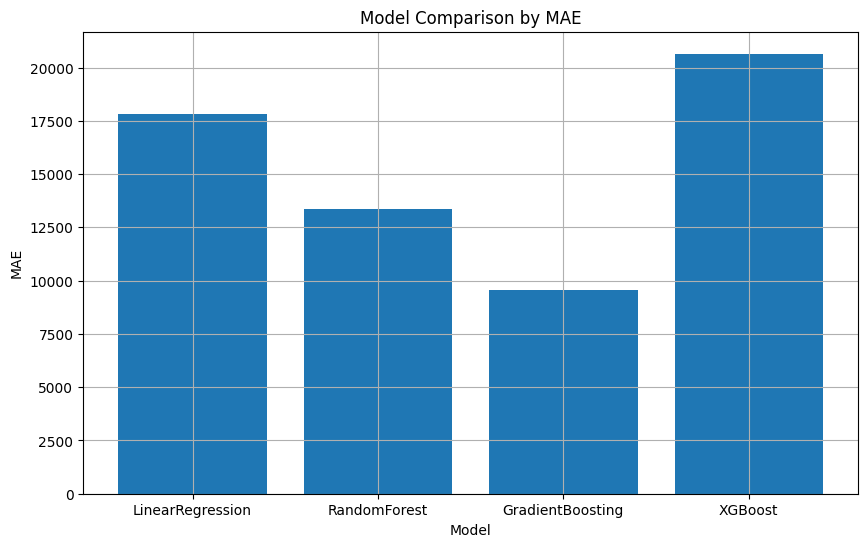

In [18]:
def plot_model_metrics(results, metric='r2_score'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2_score')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')

In [19]:
import yaml

# Save model config with selected features 
# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['r2_score'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2_score'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
        'feature_sets': selected_features_dict
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")

🏆 Best Model: GradientBoosting
   R² Score: 0.9964
   MAE: 9540.15
   RMSE: 12910.47
Saved model config to ../configs/model_config.yaml
